# Transformer Anatomy
- translation task
    - encoder - decoder
    - encoder
        - convert text to embedding vector also known as context
    - decoder
        - generate words from context, one at a time
        
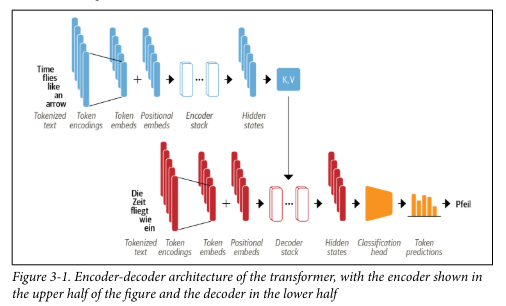

- input -> tokenize + position encoding -> Encoder layers -> to decoder layer (decoder layers) -> prediction of next token (until EOS)
- Encoder only
    - BERT
- Decoder only
    - GPT
- Encoder - Decoder
    - BART, T5
    
# Encoder
- Encoder stack
    - multi-head attention layer
    - fully connected feed forward layer (applied to each input embeddings)
    
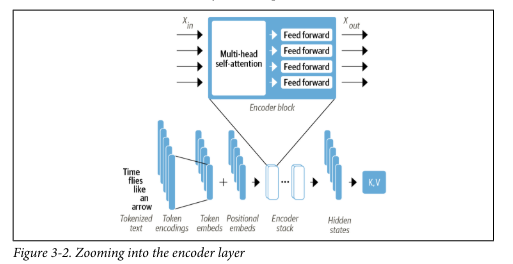

- O/p of encoded stack has same lenght as the embeddings
- it changes the input to capture the contextual information
- example word <b>apple</b> will update to more <b>company</b> like or <b>furit</b> like based on context
- each layer has skipp connection and normalization

### Self-Attention
- assign different weights to each element of the sequence
- embedding layer -> fixed embedding for a token (say a word apple always the embedding is same)
- self attention -> embedding will be different -> weigted avarage of each embedding
- for a sequence of <b> x<sub>1</sub>...x<sub>n</sub> </b> self attention produce a sequence of new embeddings <b> x<sup>'</sup><sub>1</sub>...x<sup>'</sup><sub>n</sub> </b> where each <b> x<sup>'</sup><sub>i</sub> </b> is a linear combination of <b> x<sub>j</sub> </b>
    - <b> x<sup>'</sup><sub>i</sub> = <sub>j=1</sub> ∑ <sup>n</sup> w<sub>ji</sub> x<sub>j</sub> </b> 

- w: attention weights   
- weights are normalized sum(W) = 1


### Scaled dot-product attention

- how to find attention?
- <i>from the paper Transfomrer architecture</i>
- project token embeddings to 3 vectors
    - query
    - key
    - value
- compute attention scores
    - how much query and key values are related (smilarity function)
    - dot product between embeddings
    - similar keys and querys has a large dot product
    - the dot product called attention scores
    - an input of n has nxn attention scores
- attention weights
    - the dot product is an arbitary value (any value)
    - normalized these values
        - normalize variance and then softmax -> sum = 1
        - nxn matrix with sum = 1
- now v(1,n) . w(n, n) -> v'(1, n)

### visualize the attention weights
- BertViz lib (page 88)

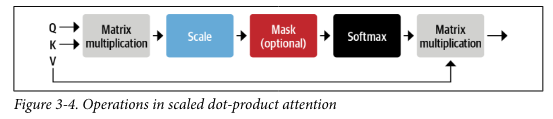

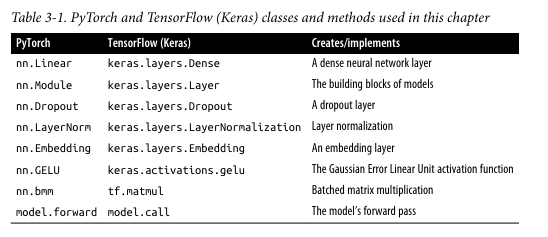

In [4]:
from transformers import AutoTokenizer

model_chkpt = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_chkpt)

text = 'time flies like an arrow'
inputs = tokenizer(
    text, return_tensors='pt', add_special_tokens=False
)

inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

- now we need to generate dense embeddings
- AutoConfig  will take the config.json file associated with the model

In [7]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_chkpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

- now need to create query, key, value

In [13]:
import torch
from math import sqrt

input_embeds = token_emb(inputs.input_ids)
print(f'input embedding size: {input_embeds.size()}')

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1, 2))/sqrt(dim_k)
scores.size()

input embedding size: torch.Size([1, 5, 768])


torch.Size([1, 5, 5])

- now we get a matrix of size 5x5
- we need to make the sum to 1
- applying softmax

In [24]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

- now attention o/p can be found by
- dot(attention weights, values)

In [26]:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [27]:
# function to generate attention
def scaled_dot_product_attention(query, key, value):
    dim_k = qery.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2))/sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return troch.bmm(weights, values)

## Multi-hed attention

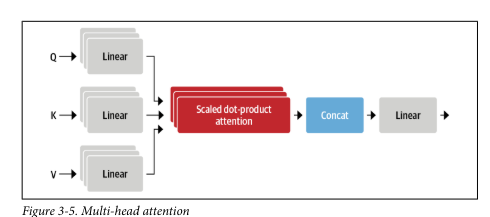

In [ ]:
class Attention(nn.Module):
    def __init__(self, embedding_dimm, head_dim):
        super.__init__()
        self.q = nn.Linear(embedding_dim, head_dim)
        self.k = nn.Linear(embedding_dim, head_dim)
        self.v = nn.Linear(embedding_dim, head_dim)
        
    def forward(self, hidden_state):
        attention_outputs = scaled_dot_products(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
        )
        
        return attention_outputs

- output: [batch_size, seq_len, head_dim]
- usual practice -> head_dim = embedding_dim/ no of attention heads
    - in bert, have 12 attention heads, so the head dim = 768/12 = 64

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super.__init__()
        embedding_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embedding_dim // num_heads
        
        self.heads = nn.ModuleList(
            [AttentionHead(embedding_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embedding_dim, embedding_dim)
        
        def forward(self, hidden_state):
            x = torch.cat([h(hidden_state) for h in self.head], dim=-1)
            x = self.output_linear(x)
            return x
        
        multihead_attn = MultiHeadAttention(config)
        attn_outputs = multihead_attn(input_embeds)
        attn_outputs.size()

- concatenate the tensor outputs to generate the Attentition output
- there is a linear layer at the out to ensure that the o/p has the same shape of the embedding

## Feed-Forward Layer
- not process the full sequence of the tokens
- porcess a single vector at a time (a word)
- also reffered as postion wise feed-forward layer
- GELU activation

In [ ]:
class FeedForward(nn.Module):
    
    def __init__(self, config):
        super.__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermeidate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x
    
feed_forward = FeedForward(config)
ff_outputs = feedforward(attn_outputs)
ff_outputs.size()

## Adding Normalization
- layer normalization
    - each bach has 0 mean and variance 1
- skip connection
    - pass the input to the output 
- 2 ways
    - post layer normalization
        - orignial transformer paper
        - tricks to train from scratch -> gradients can diverge
            - learning rate warm-up
    - pre layer normalization
        - most common method in use
        - stable during training
        
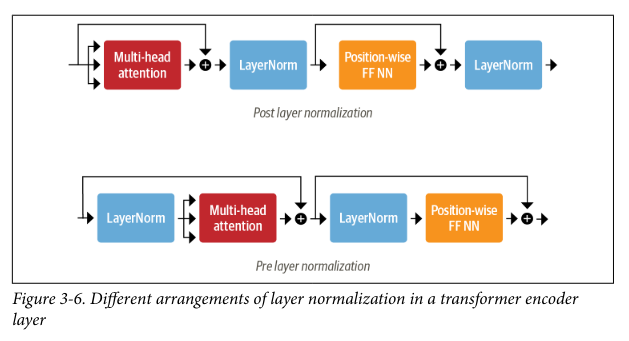

In [ ]:
class TransformerEncoderLayer(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)
        
    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x
    
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()
# (torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

## Postion Embeddings
- word postion (postion index)-> embeddings
- embeddings = postion_embedding + word_embedding

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
        config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings,
        config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()
        
    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings
    
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()
# torch.Size([1, 5, 768])

## Full Transformer encoder

In [ ]:
class TrasformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList(
            [TransformerEncoderlayer(config) for _ in range(
                config.num_hidden_layers)])
        
    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x
    
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

# torch.Size([1, 5, 768])

## Classification Head

- body + classification head
- body is task independent
- attach a classification head to the body for specific task

In [ ]:
class TransformerForSequenceClassification(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropuout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

## Decoder
- 2 additional sub-layers than encoder
    - masked multi-head self-attention layer
        - tokens generataed at each timestep are only based on past oputputs
    - Encoder decoder attention layer
        - multi-head attention over the output key and value vectors of the encoder stack
        - decoder acting as the queries
        - decoder has access to the enocder keys and values in each block
        
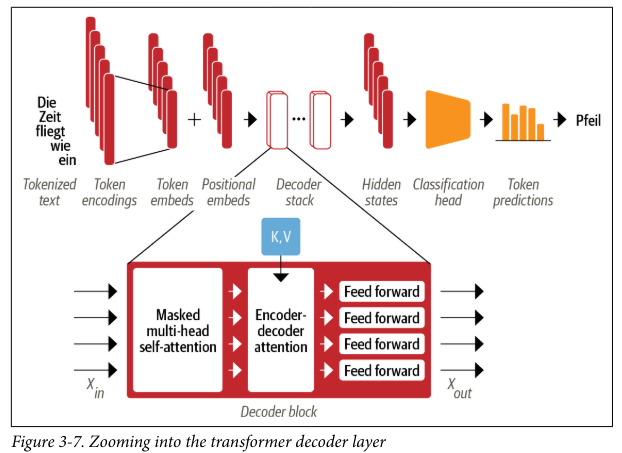

In [ ]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
print('mask')
print(mask[0])

# pytorch's tril() function to create a lower triangular matrix
# scores.masked.fill() used to fill the zeros by -inf

scores.masked_fill(mask == 0, -float('inf'))
# by setting the upper triangle as -inf, the attention weights are all zero once we take the softma over socres
# e(-inf) = 0

def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    # matrix product of query and key
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

- need to learn more about the decoder network
- 

- Transformers
    - encoder: NLU
    - decoder: NLG
    - encoder-decoder: NLU & NLG
    
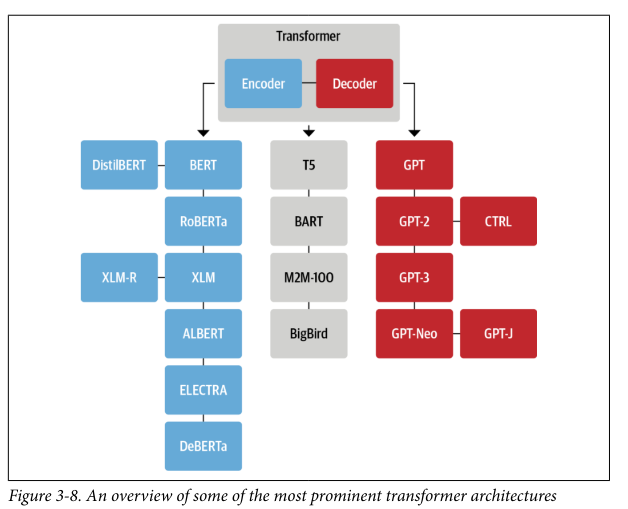